# Load Necessary Libraries
## Import Packages
* Numpy used for data structure
* matplotlib for plotting
* sklearn for data analysis/processing
* scipy for data analysis/processing
* pandas for data structure

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import pandas as pd
import os 
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,CategoricalNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from Documentation import spline_sort,simple_phase_plotter,normalize,invnormalize,\
decision_boundary_delaunay_plot,decision_boundary_delaunay

## Data Preperation 
## Import Data Into Python 

We use the program pandas and dataframes to do this.

In [49]:
#! ls
df = pd.read_csv('Classic_Phase_Diagram_Data.csv')
#print(df)
header = list(df)
phase_boundaries = [i[2:] for i in header]
phase_boundaries = list(set(phase_boundaries))

Sort into bins and interpolate phase boundaries with cubic spline from scipy

In [50]:
splinelist = []
for phaseboundary in phase_boundaries:
    splinelist.append(spline_sort(df,phaseboundary))

Discritize the system

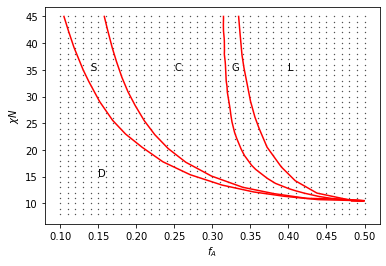

In [51]:
#setup grid
xmin = 0.1
xmax = 0.5
ymin = 8
ymax = 45
dx = 0.01
dy = 1
xarray = np.arange(xmin,xmax+1e-6,dx)
yarray = np.arange(ymin,ymax+1e-6,dy)
xx,yy = np.meshgrid(xarray,yarray)
#plot phase diagrams
plt.figure()
plt.scatter(xx,yy,c='k',s = 0.1)
plt.text(0.15,15,'D')
plt.text(0.14,35,'S')
plt.text(0.25,35,'C')
plt.text(0.325,35,'G')
plt.text(0.4,35,'L')
plt.xlabel('$f_A$')
plt.ylabel('$\chi N$')
for spline in splinelist:
    ytemp = np.linspace(spline[2][0],45,10000)
    xtemp = spline[0](ytemp)
    plt.plot(xtemp,ytemp,'r')
plt.show()

To make the dataset we are going to classify this the simple way by checking if points are between the spline curves and we are going to plot our result to confirm we did it correctly.

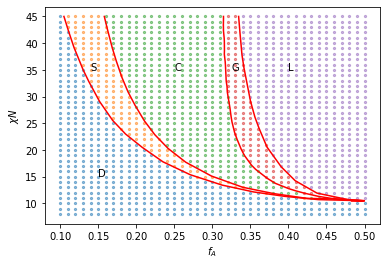

In [52]:
#We are going to classify this the dumb way
plt.figure()
plt.text(0.15,15,'D')
plt.text(0.14,35,'S')
plt.text(0.25,35,'C')
plt.text(0.325,35,'G')
plt.text(0.4,35,'L')
plt.xlabel('$f_A$')
plt.ylabel('$\chi N$')
for spline in splinelist:
    ytemp = np.linspace(spline[2][0],45,10000)
    xtemp = spline[0](ytemp)
    plt.plot(xtemp,ytemp,'r')
shape = np.shape(yy)
zz = np.zeros_like(xx)
#0 D/DIS
#1 S/BCC
#2 C/HEX
#3 G/GYR
#4 L/LAM
spinloc = np.where(yy[:,0]>10.5)[0]
for i in range(np.min(spinloc),shape[0],1):
    boundaries = np.zeros(len(splinelist)+2)
    boundaries[-1]=1
    for j in range(0,len(splinelist),1):
        boundaries[j+1] = splinelist[j][0](yy[i,0])
    boundaries = np.sort(boundaries)
    lowerbound = np.min(xx[i,:])
    upperbound = np.max(xx[i,:])
    boundaries[0] = lowerbound-dx
    boundaries[-1] = upperbound+dx
    for j in range(0,len(boundaries)-1,1):
        phaseloc = np.where((xx[i,:]>boundaries[j])&(xx[i,:]<boundaries[j+1]))
        if len(phaseloc[0]>0):
            zz[i,phaseloc[0]] = j
phase = np.unique(zz)
for i in range(0,len(phase)+1,1):
    phaseloc = np.where(zz==i)
    plt.scatter(xx[phaseloc[0],phaseloc[1]],yy[phaseloc[0],phaseloc[1]],alpha = 0.5,s = 5.0)
plt.show()

We can always save numpy arrays using this method we will utilize this later on.

In [53]:
np.savetxt('xclass.dat',xx)    
np.savetxt('yclass.dat',yy)    
np.savetxt('zclass.dat',zz)    

# Normalizing Data and Classification 
In the example shown below we normalize using a function called "normalize" between 0 and 1. One should note that there are more applicable methods in sklearn that do it more generally

First we load the necessary parameters and methods

In [54]:
#Define Parameters
xx = np.loadtxt('xclass.dat')
yy = np.loadtxt('yclass.dat')
zz = np.loadtxt('zclass.dat')
xdata = np.ravel(xx)
ydata = np.ravel(yy)
zdata = np.ravel(zz)
plt.close('all')
np.random.seed(400)
xmin = np.min(xdata)
xmax = np.max(xdata)
dx = xdata[1]-xdata[0]
ymin = np.min(ydata)
ymax = np.max(ydata)
dy = ydata[1]-ydata[0]
df = pd.read_csv('Classic_Phase_Diagram_Data.csv')
#print(df)
header = list(df)
phase_boundaries = [i[2:] for i in header]
phase_boundaries = list(set(phase_boundaries))
splinelist = []
for phaseboundary in phase_boundaries:
    splinelist.append(spline_sort(df,phaseboundary))
coordinate_data = np.vstack((xdata,ydata)).transpose()
#Define Methods
methods_names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
methods_list = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=0.001, max_iter=5000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

We load and iteratively run through the all the methods we specified. In this section we run each method on the entire dataset. 

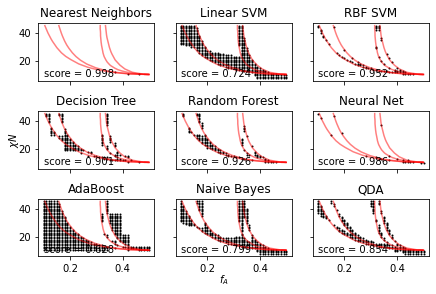

In [55]:
fig, ax = plt.subplots(3, 3,sharex=True, sharey=True)
x = [0,0,0,1,1,1,2,2,2]
y = [0,1,2,0,1,2,0,1,2]
i =0
for name, clf in zip(methods_names,methods_list):
    norm_coorddata = normalize(coordinate_data,xmin,xmax,ymin,ymax)
    clf.fit(norm_coorddata,zdata)
    score = clf.score(norm_coorddata, zdata)
    ztemp = clf.predict(norm_coorddata)
    zerror = abs(ztemp-zdata)
    zloc = np.where(zerror!=0)[0]
    coord_inv = invnormalize(norm_coorddata,xmin,xmax,ymin,ymax)
    for spline in splinelist:
        ytemp = np.linspace(spline[2][0],45,10000)
        xtemp = spline[0](ytemp)
        ax[x[i],y[i]].set_title(name)
        ax[x[i],y[i]].plot(xtemp,ytemp,'r',alpha = 0.5)
    if len(zloc)>0:
        ax[x[i],y[i]].scatter(coord_inv[zloc,0],coord_inv[zloc,1],c='k',s = 1.0)
    ax[x[i],y[i]].text(1.0*xmin,1.1*ymin,f'score = {score:0.3f}')
    i+=1
fig.text(0.5, 0.015,'$f_A$' , ha='center', va='center')
fig.text(0.015, 0.5, '$\chi N$', ha='center', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

We are not going to be tuning these classifiers to an extreme amount, but we want to at least make sure they perform reasonable well before going forward. We will show results from our tuning below for the entire dataset and the rough "score" if the score is greater than 0.8 for methods that involve hyperparameters we progress forward, if not we changed the default parameters until it performed beter:

\begin{equation}
    \texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)
\end{equation}

Note: Gaussian Process is very slow on large datasets so I took a smaller dataset and it performed reasonably well 
out of the box. I also do realize Naive Bayes is not performing well, but it does not have hyperparameters that require tuning


## Normalizing-Splitting-Training-Classification
We use these user defined functions to run the results shown in the presentation we have commented out some of the lines

In [56]:
def Run_Test_Case(method,testsize,randomstate,xdata,ydata):
    norm_coorddata = normalize(xdata,xmin,xmax,ymin,ymax)

    X_train, X_test, y_train, y_test = \
        train_test_split(norm_coorddata,ydata, test_size=testsize, random_state=randomstate)
    method.fit(X_train,y_train)
    return method.score(X_test, y_test)
def Run_Test_Case_ALL(method,testsize,randomstate,xdata,ydata):
    norm_coorddata = normalize(xdata,xmin,xmax,ymin,ymax)

    X_train, X_test, y_train, y_test = \
        train_test_split(norm_coorddata,ydata, test_size=testsize, random_state=randomstate)
    method.fit(X_train,y_train)
    return method.score(norm_coorddata, ydata)
##Values used in Presentation
#repeat = 10
#ratio = np.round(np.arange(0.05,0.95+1e-6,0.05),2)
#seed = np.random.randint(1,1000,repeat)
repeat = 1
np.random.seed(400)
ratio = np.round(np.arange(0.90,0.95+1e-6,0.05),2)
seed = np.random.randint(1,1000,repeat)
for name, clf in zip(methods_names,methods_list):
    methodarray =  np.zeros((len(ratio),repeat))
    for i in range(0,len(ratio),1):
        for j in range(0,repeat,1):
            methodarray[i,j] = Run_Test_Case_ALL(clf,ratio[i],seed[j],coordinate_data,zdata)
#    np.save(name+'_all.npy',methodarray)

We analyze these by loading in data we have already generated. We take the average and for uncertainty we compute an 95% confidence uncertainty interval.

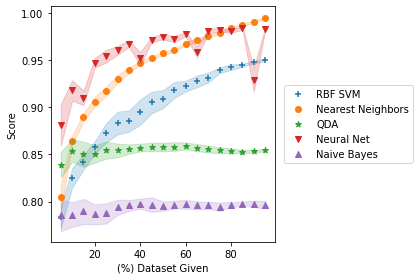

In [57]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return np.array([m, m-h, m+h])
files = ['RBF SVM.npy','Nearest Neighbors.npy','QDA.npy','Neural Net.npy','Naive Bayes.npy']
files = ['RBF SVM_all.npy','Nearest Neighbors_all.npy','QDA_all.npy','Neural Net_all.npy','Naive Bayes_all.npy']
color  = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ratio = (1-np.round(np.arange(0.05,0.95+1e-6,0.05),2))*100
plt.close('all')
fig, ax = plt.subplots()
marker = ('+', 'o', '*','v','^','<','>','s','p','h','H','x')
count = 0
for file in files:
    array = np.load(file)
    shape = np.shape(array)
    mCI = np.zeros((shape[0],3))
    for i in range(0,shape[0]):
        mCI[i,:] = mean_confidence_interval(array[i,:]) 
    name = file[:-8]
    ax.scatter(ratio,mCI[:,0],color= color[count],marker = marker[count],label = name)
    ax.fill_between(ratio, (mCI[:,1]), (mCI[:,2]), color=color[count], alpha=.2)
    count+=1
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.xlabel('(%) Dataset Given')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('percentagedatagiven_main.jpg',dpi = 300)

For the smaller dataset we do something similar instead we add Gaussian Process again the actual values are commented the code takes a bit of time to run. Note you should not run guassian process with higher dataset when in doubt use the time library in python to benchmark times!

In [58]:
methods_names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
methods_list = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0),max_iter_predict=500,n_jobs=2),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=0.001, max_iter=5000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
np.random.seed(400)
#repeat = 10
#ratio = np.round(np.arange(0.79,0.95+1e-6,0.02),2)
repeat = 1
ratio = np.round(np.arange(0.79,0.81+1e-6,0.02),2)
seed = np.random.randint(1,10000,repeat)
for name, clf in zip(methods_names,methods_list):
    methodarray =  np.zeros((len(ratio),repeat))
    for i in range(0,len(ratio),1):
        for j in range(0,repeat,1):
            methodarray[i,j] = Run_Test_Case_ALL(clf,ratio[i],seed[j],coordinate_data,zdata)
#    np.save(name+'_small_all.npy',methodarray)

Using the same code above we load in all the datafiles that we have ran and we can plot them nicely below:

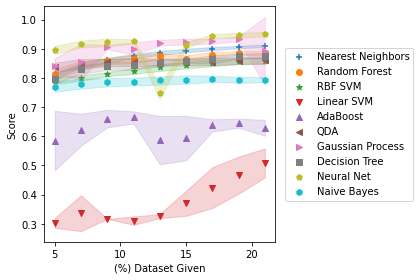

In [59]:
allfiles = os.listdir()
files = []
for file in allfiles:
    if file.find('small_all.npy')!=-1:
        files.append(file)
color  = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ratio = (1-np.round(np.arange(0.79,0.95+1e-6,0.02),2))*100
plt.close('all')
fig, ax = plt.subplots()
marker = ('+', 'o', '*','v','^','<','>','s','p','h','H','x')
count = 0
for file in files:
    array = np.load(file)
    shape = np.shape(array)
    mCI = np.zeros((shape[0],3))
    for i in range(0,shape[0]):
        mCI[i,:] = mean_confidence_interval(array[i,:]) 
    name = file[:-14]
    ax.scatter(ratio,mCI[:,0],color= color[count],marker = marker[count],label = name)
    ax.fill_between(ratio, (mCI[:,1]), (mCI[:,2]), color=color[count], alpha=.2)
    count+=1
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.xlabel('(%) Dataset Given')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('percentagedatagiven_main.jpg',dpi = 300)

# Decision Boundaries

Most methods online will send you to use countourf in matplotib to visualize decision boundaries, but solutions return relatively messy data and the mapping is often off as we need to convert from pixel space back to our space. Instead I have decided to use a Delaunay Mesh to create phase diagrams

(15.0, 20.0)

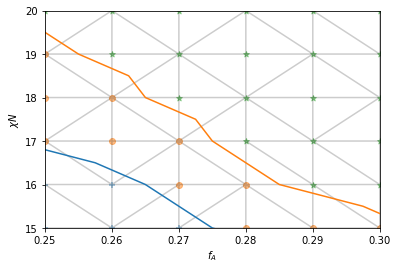

In [60]:
plt.close('all')
xx = np.loadtxt('xclass.dat')
yy = np.loadtxt('yclass.dat')
zz = np.loadtxt('zclass.dat')
yloc = np.where(yy>11)
xdata = xx[yloc[0],yloc[1]]
ydata = yy[yloc[0],yloc[1]]
zdata = zz[yloc[0],yloc[1]]
xmin = np.min(xdata)
xmax = np.max(xdata)
dx = xdata[1]-xdata[0]
ymin = np.min(ydata)
ymax = np.max(ydata)
dy = ydata[1]-ydata[0]
coordinate_data = np.vstack((xdata,ydata)).transpose()
full_boundaries = decision_boundary_delaunay_plot(coordinate_data,zdata)
plt.xlim(0.25,0.3)
plt.ylim(15,20)

With delaunay meshes we define our boundaries by taking midpoints of two points when they are different phases. If I have multiple at a $\chi N$ then I average the points in that boundary. An Example of the mesh zoomed in is shown above.

In [61]:
full_boundaries = decision_boundary_delaunay(coordinate_data,zdata)

color  = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
marker = ('+', 'o', '*','v','^','<','>','s','p','h','H','x')
methods_names = ["Nearest Neighbors", "Gaussian Process","Neural Net"]
methods_list = [
    KNeighborsClassifier(3),
    GaussianProcessClassifier(1.0 * RBF(1.0),max_iter_predict=500,n_jobs=2),
    MLPClassifier(alpha=0.001, max_iter=5000)]

 


Here we plot the Delaunay decision boundary of the classic phase diagram. This is the best we can hope for in our other methods.

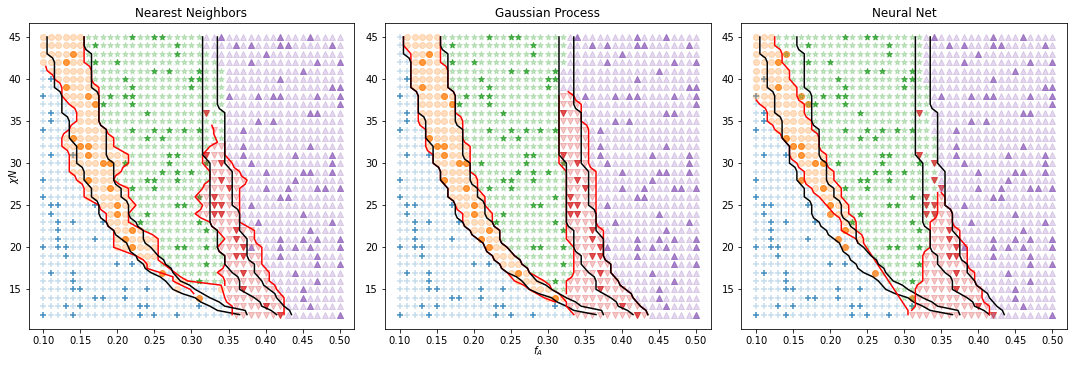

In [62]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
count = 0
for name, clf in zip(methods_names,methods_list):
    norm_coorddata = normalize(coordinate_data,xmin,xmax,ymin,ymax)
    X_train, X_test, y_train, y_test = \
        train_test_split(norm_coorddata,zdata, test_size=0.85, random_state=10)
    clf.fit(X_train,y_train)
    score = clf.score(norm_coorddata, zdata)
    ztemp = clf.predict(norm_coorddata)
    Xtraininv = invnormalize(X_train,xmin,xmax,ymin,ymax)
    coord_inv = invnormalize(norm_coorddata,xmin,xmax,ymin,ymax)
    boundaries = decision_boundary_delaunay(coord_inv,ztemp)
    unique_species = np.unique(zdata)
    ax[count].set_title(name)
    for i in range(0,len(unique_species)):
        loc = np.where(unique_species[i]==ztemp)[0]
        ax[count].scatter(coord_inv[loc,0],coord_inv[loc,1],color = color[i],marker = marker[i],alpha = 0.25)
        loc = np.where(unique_species[i]==y_train)[0]
        ax[count].scatter(Xtraininv[loc,0],Xtraininv[loc,1],color = color[i],marker = marker[i],alpha = 0.75)
    for i in range(0,len(boundaries)):
        ax[count].plot(boundaries[i][:,0],boundaries[i][:,1],'r')
        ax[count].plot(full_boundaries[i][:,0],full_boundaries[i][:,1],'k')
    count+=1
fig.text(0.5, 0.015,'$f_A$' , ha='center', va='center')
fig.text(0.015, 0.5, '$\chi N$', ha='center', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig('15percentdata_boundaries.png',dpi = 300)
    

Here are our results. Originally I wanted to take the mean squared error to measure the error between lines, but that doesn't seem to be applicable here as the boundaries differ a bit too much.

# Active Learning
Integrating GPC and Polymer Self-Consistent Theory 
* Get phases at random points using Self-Consistent Field Theory (SCFT)  
* Use a classification method to classify system 
* Compute points that will minimize uncertainty 
* Run those some of these points using SCFT
* Rinse and Repeat

I will show the framework without SCFT, but with the dataset instead. In this case we set the $error=1-score$ in reality our metric would have to be the uncertainty in our system

First we load data again(terrible variable management I know...) 

In [63]:
xx = np.loadtxt('xclass.dat')
yy = np.loadtxt('yclass.dat')
zz = np.loadtxt('zclass.dat')
xdata = np.ravel(xx)
ydata = np.ravel(yy)
zdata = np.ravel(zz)
xmin = np.min(xdata)
xmax = np.max(xdata)
dx = xdata[1]-xdata[0]
ymin = np.min(ydata)
ymax = np.max(ydata)
dy = ydata[1]-ydata[0]

We Initialize all the details such as the start ratio (1-start_ratio) equals about 1% of the dataset. Setting tolerance, percent whenever we rechoose and max iterations 

In [64]:
color  = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
marker = ('+', 'o', '*','v','^','<','>','s','p','h','H','x')
start_ratio = 0.99
tol = 0.05
itter = 0
maxitter = 100
error = 1
percent = 0.1
coordinate_data = np.vstack((xdata,ydata)).transpose()
full_boundaries = decision_boundary_delaunay(coordinate_data,zdata)
normcoord = normalize(coordinate_data,xmin,xmax,ymin,ymax)
X_train, X_test, y_train, y_test = \
    train_test_split(normcoord,zdata, test_size=start_ratio, random_state=10)
method = GaussianProcessClassifier(1.0 * RBF(1.0),max_iter_predict=500,n_jobs=2)
coords_score = np.hstack((X_train[:,0],X_train[:,1],score*np.ones_like(y_train)))
invnorm = invnormalize(normcoord,xmin,xmax,ymin,ymax)

We run this while loop until we accomplish our objective!

In [65]:
while error>tol:
    method.fit(X_train, y_train)
    ztemp = method.predict_proba(normcoord)
    max_prob = np.max(ztemp,axis = 1)
    score = method.score(normcoord,zdata)
    loc = np.where(max_prob<0.5)[0]
    getvalue = np.random.randint(0,len(loc)-1,np.int(np.ceil(percent*len(loc))))
    
    X_train = np.vstack((X_train,normcoord[loc[getvalue],:]))
    y_train = np.hstack((y_train,zdata[loc[getvalue]]))
    error = 1-score
    print(score)
    itter+=1
    if itter>maxitter:
        break

0.6091142490372272
0.788831835686778
0.9492939666238768
0.9614890885750963


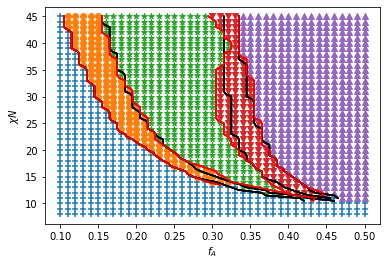

In [66]:
plt.figure()
zplot = method.predict(normcoord)
unique_species = np.unique(zplot)
for i in range(0,len(unique_species)):
    loc = np.where(unique_species[i]==zplot)[0]
    invnorm = invnormalize(normcoord,xmin,xmax,ymin,ymax)
    boundaries = decision_boundary_delaunay(invnorm,zplot)
    plt.scatter(invnorm[loc,0],invnorm[loc,1],color = color[i],marker = marker[i])
    for i in range(0,len(full_boundaries)):
        plt.plot(full_boundaries[i][:,0],full_boundaries[i][:,1],'k')
    for i in range(0,len(boundaries)):
        plt.plot(boundaries[i][:,0],boundaries[i][:,1],'r')
plt.xlabel('$f_A$')
plt.ylabel('$\chi N$')
plt.savefig('bayeschoicediagram.jpg',dpi = 300)